<a href="https://colab.research.google.com/github/natbcar/MachineLearning/blob/main/MLP_Mixer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [57]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

from tqdm import tqdm, trange
import matplotlib.pyplot as plt 
import numpy as np

from PIL import Image

# Model

## MLP Block

In [2]:
class MLPBlock(nn.Module): 
  """
  MLP block to be used by the MixerLayer class.
  """
  def __init__(self, in_dim, hidden_dim, out_dim):
    super(MLPBlock, self).__init__()

    self.linear1 = nn.Linear(in_dim, hidden_dim)  
    self.gelu = nn.GELU()
    self.linear2 = nn.Linear(hidden_dim, out_dim)

  def forward(self, x):
    x = self.linear1(x)
    x = self.gelu(x)
    return self.linear2(x)

## MixerLayer

In [40]:
class MixerLayer(nn.Module):
  """
  Class for a mixer layer as described in https://arxiv.org/pdf/2105.01601.pdf
  Contains 2 MLP blocks, one for token mixing and one for channel mixing.

  Applies layer normalization to the input of each MLP and skip connections to
  their output.
  """
  def __init__(self, hidden_dim, seq_len, token_hidden, channel_hidden):
    super(MixerLayer, self).__init__()

    self.layer_norm = nn.LayerNorm([seq_len, hidden_dim])

    self.token_mixer = MLPBlock(seq_len, token_hidden, seq_len)
    self.channel_mixer = MLPBlock(hidden_dim, channel_hidden, hidden_dim)

  def forward(self, x):
    #----- Token Mixing-------
    x_ = x  # save for skip connection
    x = self.layer_norm(x) # layer normalization
    x = x.permute(0, 2, 1) # transpose input for mlp block
    x = self.token_mixer(x)
    x = x.permute(0, 2, 1) # convert back to original size
    x = x + x_  # skip connection

    #----- Channel Mixing------
    x_ = x  # save for skip connection
    x = self.layer_norm(x)  # layer normalization
    x = self.channel_mixer(x)
    x = x + x_  # skip connection

    return x

## MLP Mixer

In [44]:
class MLPMixer(nn.Module):
  """
  Class for a MLP Mixer architecture described in https://arxiv.org/pdf/2105.01601.pdf.
  The architecture has a number of different parameters.

  num_classes (int): number of image classes in the dataset
  num_layers (int): number of mixer layers
  patch_res (int): patch resolution which is (p,p) always square
  hidden_dim (int): hidden dim size that patches are projected into
  seq_len (int): sequence length, i.e number of patches
  token_hidden (int): hidden dim for token mixing MLP
  channel_hidden (int): hidden dim for channel mixing MLP
  
  """
  def __init__(self, 
               num_classes,
               in_channels=3, 
               num_layers=8, 
               patch_res=32, 
               hidden_dim=512,
               seq_len=49,  
               token_hidden=256, 
               channel_hidden=2048):
    super(MLPMixer, self).__init__()
    self.hidden_dim = hidden_dim

    self.per_patch_fc = nn.Conv2d(in_channels=in_channels, out_channels=hidden_dim,
                                  kernel_size=patch_res, stride=patch_res)
    
    mixer_layers = [MixerLayer(hidden_dim=hidden_dim, 
                         seq_len=seq_len, 
                         token_hidden=token_hidden,
                         channel_hidden=channel_hidden) for _ in range(num_layers)]

    self.mixer = nn.Sequential(*mixer_layers)
    self.fc = nn.Linear(hidden_dim, num_classes)

  def forward(self, x):
    #==== Per-patch Fully-connected ====
    batch_size, _, _ , _ = x.shape  # x has shape (batch_size, num_channels, h, w)
    x = self.per_patch_fc(x)  # returns tensor of shape (batch_size, hidden_dim, sqrt(seq_len), sqrt(seq_len))
    x = x.permute(0, 2, 3, 1) # permute to get shape (batch_size, sqrt(seq_len), sqrt(seq_len), hidden_dim)
    # collapse the 1 and 2 dimensions to get shape (batch_size, seq_len, hidden_dim)
    x = x.contiguous().view(batch_size, -1, self.hidden_dim)  

    #==== Mixer Layers ====
    x = self.mixer(x)

    #==== Classifier ====
    x = x.mean(dim=1) # global avg pooling to get tensor of shape (batch_size, hidden_dim)
    x = self.fc(x)  # get logits

    return x

# Training

In [50]:
# image transforms
transform = transforms.Compose([
                                transforms.Resize(224),  # resize to (224,224)
                                transforms.ToTensor(),   # convert to tensor
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize
                                ])

In [51]:
train = datasets.STL10(root='./', split='train', transform=transform, download=True)
test = datasets.STL10(root='./', split='test', transform=transform, download=True)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./stl10_binary.tar.gz to ./
Files already downloaded and verified


In [80]:
batch_size = 64
num_epochs = 25

In [91]:
mlp_mixer = MLPMixer(10).cuda()  # stl10 has 10 classes
loss_fn = nn.CrossEntropyLoss().cuda()
optim = torch.optim.Adam(params=mlp_mixer.parameters())

In [92]:
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=True)

In [93]:
training_loss = []
training_accuracy = []
validation_loss = []
validation_accuracy = []

In [94]:
for epoch in range(num_epochs):
  mlp_mixer.train()
  with tqdm(train_loader, unit="batch") as tepoch:
    for X, y in tepoch:
      tepoch.set_description(f"Epoch {epoch}")

      #=== Forward Pass ===
      X, y = X.cuda(), y.cuda() 
      pred_y = mlp_mixer(X) 
      loss = loss_fn(pred_y, y) 
      training_loss.append(loss.item())

      #=== Backprop ===
      optim.zero_grad()
      loss.backward()
      optim.step()

      # update progress bar
      pred_y = pred_y.argmax(dim=1, keepdim=True).squeeze()
      accuracy = (pred_y == y).sum().item() / len(X)
      training_accuracy.append(accuracy)
      tepoch.set_postfix(loss=loss.item(), accuracy=100 * accuracy)

  #=== Validation ===
  with torch.no_grad():
    mlp_mixer.eval()
    size = len(test_loader.dataset)
    avg_loss, avg_acc = 0, 0
    for X, y in test_loader:
      X, y = X.cuda(), y.cuda()
      pred_y = mlp_mixer(X)
      avg_loss += loss_fn(pred_y, y).item()
      avg_acc += (pred_y.argmax(1) == y).sum().item()

    avg_loss /= size
    avg_acc /= size

    validation_loss.append(avg_loss)
    validation_accuracy.append(avg_acc)

Epoch 24: 100%|██████████| 79/79 [00:35<00:00,  2.24batch/s, accuracy=100, loss=0.000375]


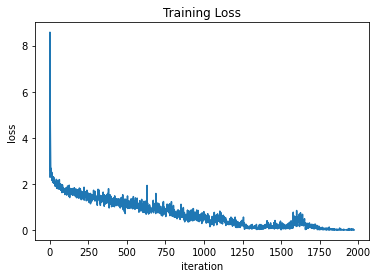

In [95]:
plt.plot([i for i in range(len(training_loss))], training_loss)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Training Loss')
plt.show()

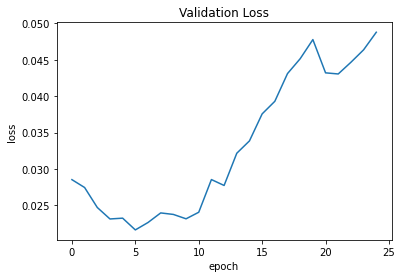

In [96]:
plt.plot([i for i in range(len(validation_loss))], validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Validation Loss')
plt.show()

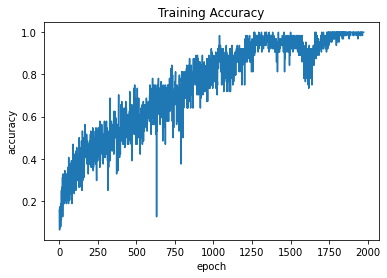

In [98]:
plt.plot([i for i in range(len(training_accuracy))], training_accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training Accuracy')
plt.show()

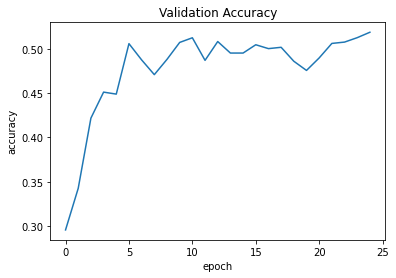

In [97]:
plt.plot([i for i in range(len(validation_accuracy))], validation_accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Validation Accuracy')
plt.show()

In [106]:
# compute accuracy
mlp_mixer.eval()
with torch.no_grad():
  num_correct = 0
  for X, y in test_loader:
    X, y = X.cuda(), y.cuda()
    y_pred = mlp_mixer(X)
    num_correct += (y_pred.argmax(1) == y).sum().item()

  accuracy = num_correct / len(test_loader.dataset)

print(f"Accuracy: {accuracy * 100}")

Accuracy: 51.87500000000001
